# Tutorial Part 3: Modeling Solubility


Computationally predicting molecular solubility through is useful for drug-discovery. In this tutorial, we will use the `deepchem` library to fit a simple statistical model that predicts the solubility of drug-like compounds. The process of fitting this model involves four steps:

1. Loading a chemical dataset, consisting of a series of compounds along with aqueous solubility measurements.
2. Transforming each compound into a feature vector $v \in \mathbb{R}^n$ comprehensible to statistical learning methods.
3. Fitting a simple model that maps feature vectors to estimates of aqueous solubility.
4. Visualizing the results.

## Colab

This tutorial and the rest in this sequence are designed to be done in Google colab. If you'd like to open this notebook in colab, you can use the following link.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deepchem/deepchem/blob/master/examples/tutorials/03_Modeling_Solubility.ipynb)

## Setup

To run DeepChem within Colab, you'll need to run the following cell of installation commands. This will take about 5 minutes to run to completion and install your environment.

In [1]:
%tensorflow_version 1.x
!curl -Lo deepchem_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
import deepchem_installer
%time deepchem_installer.install(version='2.3.0')

TensorFlow 1.x selected.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3477  100  3477    0     0   9766      0 --:--:-- --:--:-- --:--:--  9766


add /root/miniconda/lib/python3.6/site-packages to PYTHONPATH
python version: 3.6.9
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
done
installing deepchem
done
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



deepchem-2.3.0 installation finished!


CPU times: user 2.61 s, sys: 560 ms, total: 3.17 s
Wall time: 1min 59s


We need to load a dataset of estimated aqueous solubility measurements [1] into deepchem. The data is in CSV format and contains SMILES strings, predicted aqueaous solubilities, and a number of extraneous (for our purposes) molecular properties. Here is an example line from the dataset:

<table style="width:100%">
  <tr>
    <th> Compound ID </th>
    <th> ESOL predicted log solubility (mols/liter) </th> 
      <th> Minimum Degree </th> 
      <th> Molecular Weight </th>
      <th> # H-Bond Donors </th>
      <th> # Rings </th>
      <th> # Rotatable Bonds </th>
      <th> Polar Surface Area </th>
      <th> Measured log solubility (mols/liter) </th>
      <th> smiles </th>
  </tr>
  <tr>
    <td>benzothiazole</td>
    <td>-2.733</td> 
    <td>2</td>
      <td> 135.191 </td>
      <td> 0 </td>
      <td> 2 </td>
      <td> 0 </td>
      <td> 12.89 </td>
      <td> -1.5 </td>
      <td> c2ccc1scnc1c2 </td> 
  </tr>

</table>


Most of these fields are not useful for our purposes. The two fields that we will need are the "smiles" field and the "measured log solubility in mols per litre". The "smiles" field holds a SMILES string [2] that specifies the compound in question. Before we load this data into deepchem, we will load the data into python and do some simple preliminary analysis to gain some intuition for the dataset. We'll pull this dataset down from the DeepChem github repo. (If you're running this tutorial on a Mac, you may need to run `brew install wget` to get this command)

In [2]:
!wget https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv

--2020-06-12 02:18:23--  https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96699 (94K) [text/plain]
Saving to: ‘delaney-processed.csv’

delaney-processed.c 100%[===================>]  94.43K  --.-KB/s    in 0.009s  

2020-06-12 02:18:23 (10.1 MB/s) - ‘delaney-processed.csv’ saved [96699/96699]



In [3]:
from deepchem.utils.save import load_from_disk

dataset_file= "delaney-processed.csv"
dataset = load_from_disk(dataset_file)
print("Columns of dataset: %s" % str(dataset.columns.values))
print("Number of examples in dataset: %s" % str(dataset.shape[0]))

Columns of dataset: ['Compound ID' 'ESOL predicted log solubility in mols per litre'
 'Minimum Degree' 'Molecular Weight' 'Number of H-Bond Donors'
 'Number of Rings' 'Number of Rotatable Bonds' 'Polar Surface Area'
 'measured log solubility in mols per litre' 'smiles']
Number of examples in dataset: 1128


To gain a visual understanding of compounds in our dataset, let's draw them using rdkit. We define a couple of helper functions to get started.

In [0]:
import tempfile
from rdkit import Chem
from rdkit.Chem import Draw
from itertools import islice
from IPython.display import Image, display

def display_images(filenames):
    """Helper to pretty-print images."""
    for file in filenames:
      display(Image(file))

def mols_to_pngs(mols, basename="test"):
    """Helper to write RDKit mols to png files."""
    filenames = []
    for i, mol in enumerate(mols):
        filename = "%s%d.png" % (basename, i)
        Draw.MolToFile(mol, filename)
        filenames.append(filename)
    return filenames

Now, we display some compounds from the dataset:

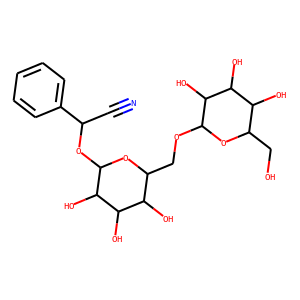

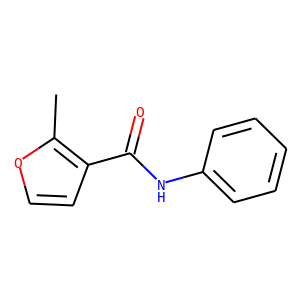

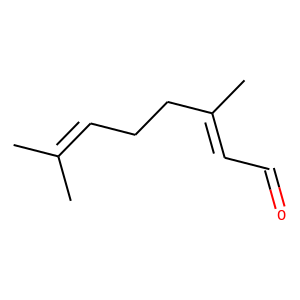

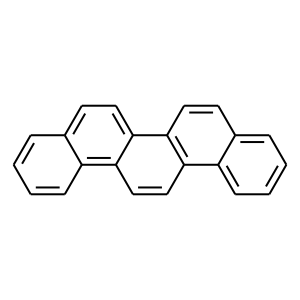

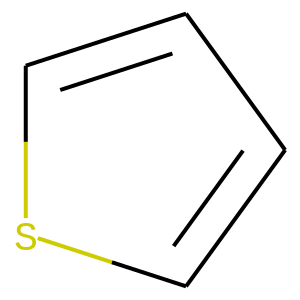

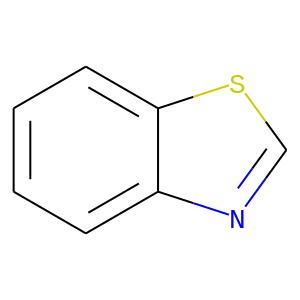

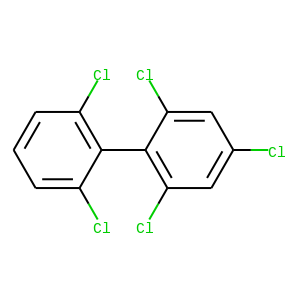

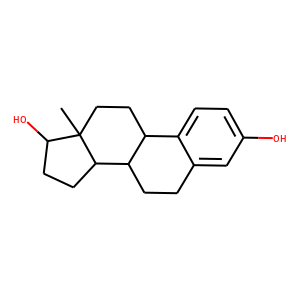

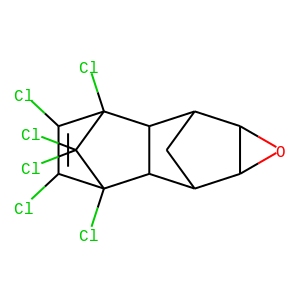

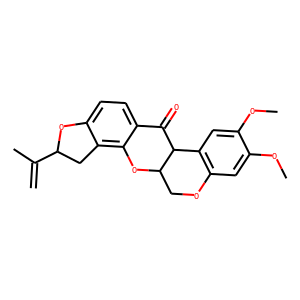

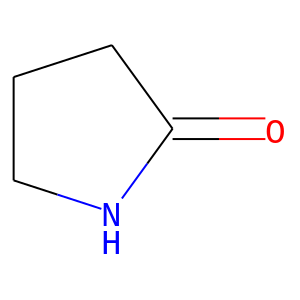

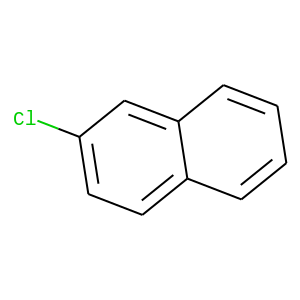

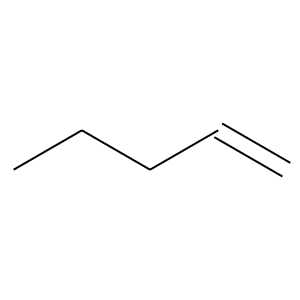

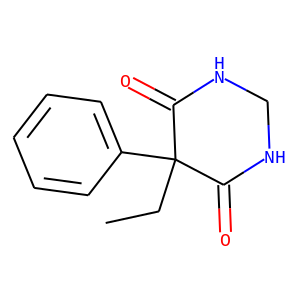

In [5]:
num_to_display = 14
molecules = []
for _, data in islice(dataset.iterrows(), num_to_display):
    molecules.append(Chem.MolFromSmiles(data["smiles"]))
display_images(mols_to_pngs(molecules))

Analyzing the distribution of solubilities shows us a nice spread of data.

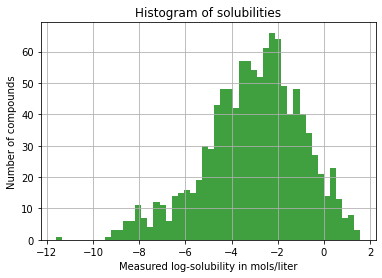

In [6]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

solubilities = np.array(dataset["measured log solubility in mols per litre"])
n, bins, patches = plt.hist(solubilities, 50, facecolor='green', alpha=0.75)
plt.xlabel('Measured log-solubility in mols/liter')
plt.ylabel('Number of compounds')
plt.title(r'Histogram of solubilities')
plt.grid(True)
plt.show()


With our preliminary analysis completed, we return to the original goal of constructing a predictive statistical model of molecular solubility using `deepchem`. The first step in creating such a molecule is translating each compound into a vectorial format that can be understood by statistical learning techniques. This process is commonly called featurization. `deepchem` packages a number of commonly used featurization for user convenience. In this tutorial, we will use ECPF4 fingeprints [3].

`deepchem` offers an object-oriented API for featurization. To get started with featurization, we first construct a ```Featurizer``` object. `deepchem` provides the ```CircularFingeprint``` class (a subclass of ```Featurizer``` that performs ECFP4 featurization).


In [0]:
import deepchem as dc

featurizer = dc.feat.CircularFingerprint(size=1024)

Now, let's perform the actual featurization. `deepchem` provides the ```CSVLoader``` class for this purpose. The ```featurize()``` method for this class loads data from disk and uses provided ```Featurizer```instances to transform the provided data into feature vectors. 

To perform machine learning upon these datasets, we need to convert the samples into datasets suitable for machine-learning (that is, into data matrix $X \in \mathbb{R}^{n\times d}$ where $n$ is the number of samples and $d$ the dimensionality of the feature vector, and into label vector $y \in \mathbb{R}^n$). `deepchem` provides the `Dataset` class to facilitate this transformation. This style lends itself easily to validation-set hyperparameter searches, which we illustate below. 

In [8]:
loader = dc.data.CSVLoader(
      tasks=["measured log solubility in mols per litre"], smiles_field="smiles",
      featurizer=featurizer)
dataset = loader.featurize(dataset_file)

Loading raw samples now.
shard_size: 8192
About to start loading CSV from delaney-processed.csv
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
TIMING: featurizing shard 0 took 3.569 s
TIMING: dataset construction took 3.629 s
Loading dataset from disk.


When constructing statistical models, it's necessary to separate the provided data into train/test subsets. The train subset is used to learn the statistical model, while the test subset is used to evaluate the learned model. In practice, it's often useful to elaborate this split further and perform a train/validation/test split. The validation set is used to perform model selection. Proposed models are evaluated on the validation-set, and the best performed model is at the end tested on the test-set.

Choosing the proper method of performing a train/validation/test split can be challenging. Standard machine learning practice is to perform a random split of the data into train/validation/test, but random splits are not well suited for the purposes of chemical informatics. For our predictive models to be useful, we require them to have predictive power in portions of chemical space beyond the set of molecules in the training data. Consequently, our models should use splits of the data that separate compounds in the training set from those in the validation and test-sets. We use Bemis-Murcko scaffolds [5] to perform this separation (all compounds that share an underlying molecular scaffold will be placed into the same split in the train/test/validation split).


In [9]:
splitter = dc.splits.ScaffoldSplitter(dataset_file)
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(
    dataset)

Computing train/valid/test indices
About to generate scaffolds
Generating scaffold 0/1128
Generating scaffold 1000/1128
About to sort in scaffold sets
TIMING: dataset construction took 0.054 s
Loading dataset from disk.
TIMING: dataset construction took 0.029 s
Loading dataset from disk.
TIMING: dataset construction took 0.032 s
Loading dataset from disk.


Let's visually inspect some of the molecules in the separate splits to verify that they appear structurally dissimilar. The `FeaturizedSamples` class provides an `itersamples` method that lets us obtain the underlying compounds in each split.

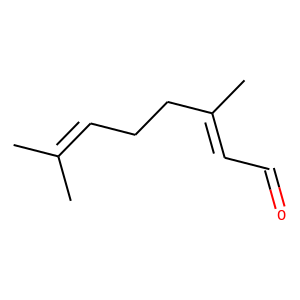

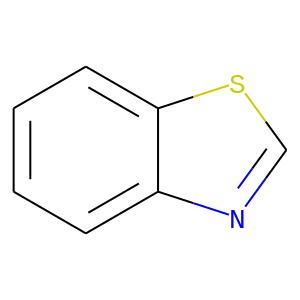

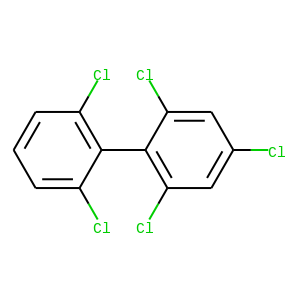

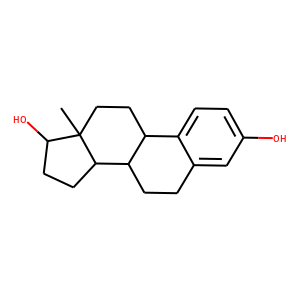

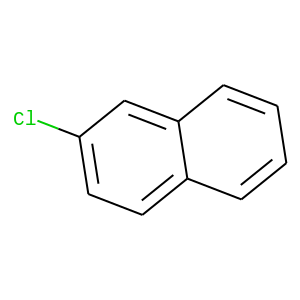

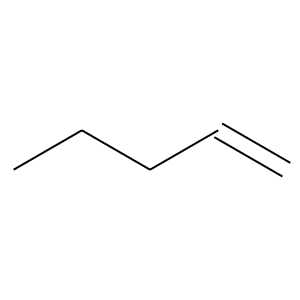

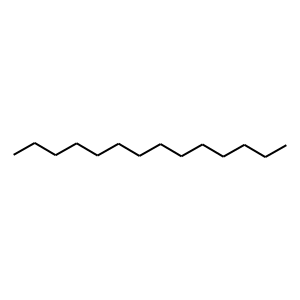

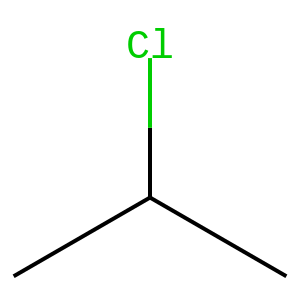

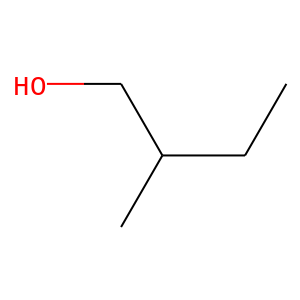

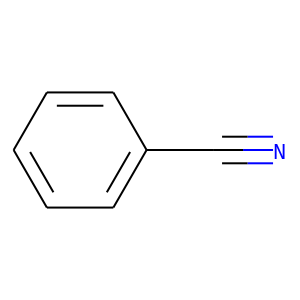

In [10]:
train_mols = [Chem.MolFromSmiles(compound)
              for compound in train_dataset.ids]
display_images(mols_to_pngs(train_mols[:10], basename="train"))

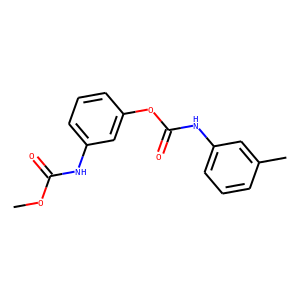

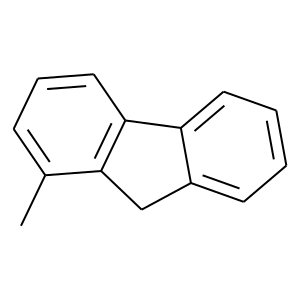

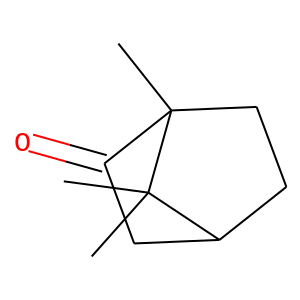

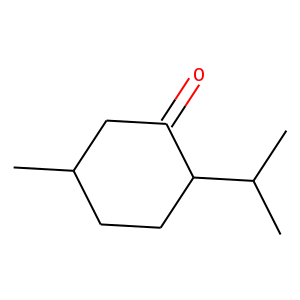

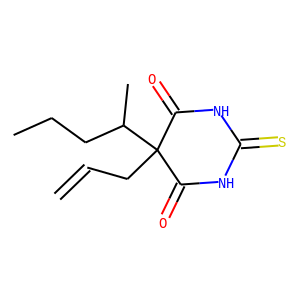

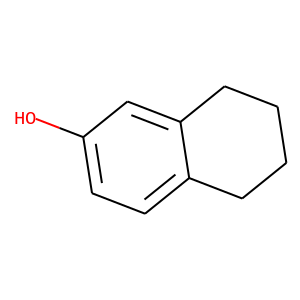

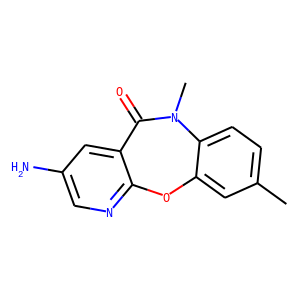

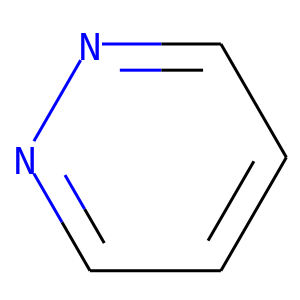

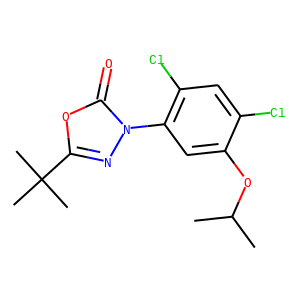

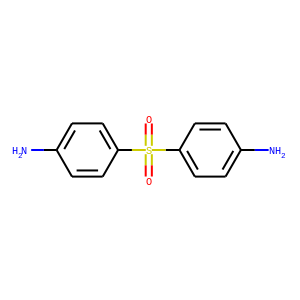

In [11]:
valid_mols = [Chem.MolFromSmiles(compound)
              for compound in valid_dataset.ids]
display_images(mols_to_pngs(valid_mols[:10], basename="valid"))

Notice the visual distinction between the train/validation splits. The most-common scaffolds are reserved for the train split, with the rarer scaffolds allotted to validation/test.

The performance of common machine-learning algorithms can be very sensitive to preprocessing of the data. One common transformation applied to data is to normalize it to have zero-mean and unit-standard-deviation. We will apply this transformation to the log-solubility (as seen above, the log-solubility ranges from -12 to 2).

In [12]:
transformers = [
    dc.trans.NormalizationTransformer(transform_y=True, dataset=train_dataset)]

for dataset in [train_dataset, valid_dataset, test_dataset]:
  for transformer in transformers:
      dataset = transformer.transform(dataset)

TIMING: dataset construction took 0.047 s
Loading dataset from disk.
TIMING: dataset construction took 0.011 s
Loading dataset from disk.
TIMING: dataset construction took 0.010 s
Loading dataset from disk.


The next step after processing the data is to start fitting simple learning models to our data. `deepchem` provides a number of machine-learning model classes.

In particular, `deepchem` provides a convenience class, ```SklearnModel``` that wraps any machine-learning model available in scikit-learn [6]. Consequently, we will start by building a simple random-forest regressor that attempts to predict the log-solubility from our computed ECFP4 features. To train the model, we instantiate the ```SklearnModel``` object, then call the ```fit()``` method on the ```train_dataset``` we constructed above. We then save the model to disk.

In [0]:
from sklearn.ensemble import RandomForestRegressor

sklearn_model = RandomForestRegressor(n_estimators=100)
model = dc.models.SklearnModel(sklearn_model)
model.fit(train_dataset)

We next evaluate the model on the validation set to see its predictive power. `deepchem` provides the `Evaluator` class to facilitate this process. To evaluate the constructed `model` object, create a new `Evaluator` instance and call the `compute_model_performance()` method.

In [14]:
from deepchem.utils.evaluate import Evaluator

metric = dc.metrics.Metric(dc.metrics.r2_score)
evaluator = Evaluator(model, valid_dataset, transformers)
r2score = evaluator.compute_model_performance([metric])
print(r2score)


computed_metrics: [0.1564123392340252]
{'r2_score': 0.1564123392340252}


The performance of this basic random-forest model isn't very strong. To construct stronger models, let's attempt to optimize the hyperparameters (choices made in the model-specification) to achieve better performance. For random forests, we can tweak `n_estimators` which controls the number of trees in the forest, and `max_features` which controls the number of features to consider when performing a split. We now build a series of `SklearnModel`s with different choices for `n_estimators` and `max_features` and evaluate performance on the validation set.

In [15]:
def rf_model_builder(model_params, model_dir):
  sklearn_model = RandomForestRegressor(**model_params)
  return dc.models.SklearnModel(sklearn_model, model_dir)
params_dict = {
    "n_estimators": [10, 100],
    "max_features": ["auto", "sqrt", "log2", None],
}

metric = dc.metrics.Metric(dc.metrics.r2_score)
optimizer = dc.hyper.HyperparamOpt(rf_model_builder)
best_rf, best_rf_hyperparams, all_rf_results = optimizer.hyperparam_search(
    params_dict, train_dataset, valid_dataset, transformers,
    metric=metric)

Fitting model 1/8
hyperparameters: {'n_estimators': 10, 'max_features': 'auto'}
computed_metrics: [0.11429830055719803]
Model 1/8, Metric r2_score, Validation set 0: 0.114298
	best_validation_score so far: 0.114298
Fitting model 2/8
hyperparameters: {'n_estimators': 10, 'max_features': 'sqrt'}
computed_metrics: [0.255910681043121]
Model 2/8, Metric r2_score, Validation set 1: 0.255911
	best_validation_score so far: 0.255911
Fitting model 3/8
hyperparameters: {'n_estimators': 10, 'max_features': 'log2'}
computed_metrics: [0.15376331917321695]
Model 3/8, Metric r2_score, Validation set 2: 0.153763
	best_validation_score so far: 0.255911
Fitting model 4/8
hyperparameters: {'n_estimators': 10, 'max_features': None}
computed_metrics: [0.08206916361536953]
Model 4/8, Metric r2_score, Validation set 3: 0.082069
	best_validation_score so far: 0.255911
Fitting model 5/8
hyperparameters: {'n_estimators': 100, 'max_features': 'auto'}
computed_metrics: [0.15969497770354368]
Model 5/8, Metric r2_sc

The best model achieves significantly higher $R^2$ on the validation set than the first model we constructed. Now, let's perform the same sort of hyperparameter search, but with a simple deep-network instead.

In [16]:
import numpy.random

params_dict = {"learning_rate": np.power(10., np.random.uniform(-5, -3, size=1)),
               "decay": np.power(10, np.random.uniform(-6, -4, size=1)),
               "nb_epoch": [20] }
n_features = train_dataset.get_data_shape()[0]
def model_builder(model_params, model_dir):
  model = dc.models.MultitaskRegressor(
    1, n_features, layer_sizes=[1000], dropouts=[.25],
    batch_size=50, **model_params)
  return model

optimizer = dc.hyper.HyperparamOpt(model_builder)
best_dnn, best_dnn_hyperparams, all_dnn_results = optimizer.hyperparam_search(
    params_dict, train_dataset, valid_dataset, transformers,
    metric=metric)

Fitting model 1/1
hyperparameters: {'learning_rate': 0.0004948656946205111, 'decay': 4.283485107240641e-06, 'nb_epoch': 20}
Instructions for updating:
If using Keras pass *_constraint arguments to layers.





computed_metrics: [0.27192770328945703]
Model 1/1, Metric r2_score, Validation set 0: 0.271928
	best_validation_score so far: 0.271928
computed_metrics: [0.7855675808634082]
Best hyperparameters: (0.0004948656946205111, 4.283485107240641e-06, 20)
train_score: 0.785568
validation_score: 0.271928


Now that we have a reasonable choice of hyperparameters, let's evaluate the performance of our best models on the test-set.

In [17]:
rf_test_evaluator = Evaluator(best_rf, test_dataset, transformers)
rf_test_r2score = rf_test_evaluator.compute_model_performance([metric])
print("RF Test set R^2 %f" % (rf_test_r2score["r2_score"]))

computed_metrics: [0.3447598620339224]
RF Test set R^2 0.344760


In [18]:
dnn_test_evaluator = Evaluator(best_dnn, test_dataset, transformers)
dnn_test_r2score = dnn_test_evaluator.compute_model_performance([metric])
print("DNN Test set R^2 %f" % (dnn_test_r2score["r2_score"]))

computed_metrics: [0.36426843023910316]
DNN Test set R^2 0.364268


Now, let's plot the predicted $R^2$ scores versus the true $R^2$ scores for the constructed model.

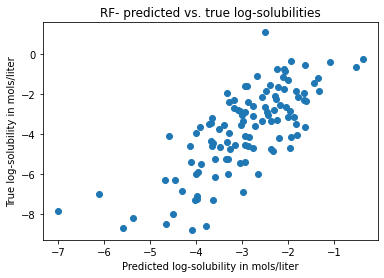

In [19]:
task = "measured log solubility in mols per litre"
predicted_test = best_rf.predict(test_dataset)
true_test = test_dataset.y
plt.scatter(predicted_test, true_test)
plt.xlabel('Predicted log-solubility in mols/liter')
plt.ylabel('True log-solubility in mols/liter')
plt.title(r'RF- predicted vs. true log-solubilities')
plt.show()

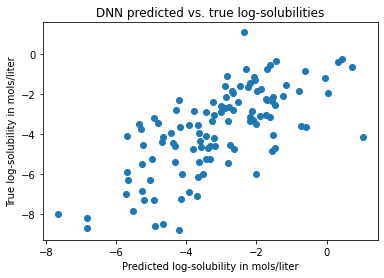

In [20]:
task = "measured log solubility in mols per litre"
predicted_test = best_dnn.predict(test_dataset)
true_test = test_dataset.y
plt.scatter(predicted_test, true_test)
plt.xlabel('Predicted log-solubility in mols/liter')
plt.ylabel('True log-solubility in mols/liter')
plt.title(r'DNN predicted vs. true log-solubilities')
plt.show()

# Congratulations! Time to join the Community!

Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:

## Star DeepChem on [GitHub](https://github.com/deepchem/deepchem)
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.

## Join the DeepChem Gitter
The DeepChem [Gitter](https://gitter.im/deepchem/Lobby) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!

# Bibliography

[1] John S. Delaney. ESOL: Estimating aqueous solubility directly from molecular structure. Journal
of Chemical Information and Computer Sciences, 44(3):1000–1005, 2004.

[2] Anderson, Eric, Gilman D. Veith, and David Weininger. SMILES, a line notation and computerized
interpreter for chemical structures. US Environmental Protection Agency, Environmental Research Laboratory, 1987.

[3] Rogers, David, and Mathew Hahn. "Extended-connectivity fingerprints." Journal of chemical information
and modeling 50.5 (2010): 742-754.
    
[4] Van Der Walt, Stefan, S. Chris Colbert, and Gael Varoquaux.
"The NumPy array:a structure for efficient numerical computation." Computing in Science & Engineering 13.2 (2011): 22-30.
    
[5] Bemis, Guy W., and Mark A. Murcko. "The properties of known drugs. 1. Molecular frameworks."
Journal of medicinal chemistry 39.15 (1996): 2887-2893.

[6] Pedregosa, Fabian, et al. "Scikit-learn: Machine learning in Python." The Journal of Machine Learning Research 12 (2011): 2825-2830.